### Dependencies

In [4]:
#@title Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.func import vmap
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision.datasets import MNIST
from tqdm.auto import tqdm, trange
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

### U-net Architecture Score-based Diffusion Model

In [5]:
#@title Defining a time-dependent score-based model (double click to expand or collapse)

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(2, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std

  def forward(self, x, t):
    # Obtain the Gaussian random feature embedding for t
    embed = self.act(self.embed(t))
    # Encoding path
    h1 = self.conv1(x)
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

### Ornstein-Uhlenbeck Stochastic Differential Equation (SDE) Setup

In [6]:
#@title Set up the SDE

device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

def marginal_prob_mean(t):
  """Compute the mean of the $p_{0t}(x(t) | x(0))$.

  Args:
      t: A vector of time steps.

  Returns:
      The mean.
  """
  t = torch.tensor(t, device=device)
  return torch.exp(-t/2)

def marginal_prob_std(t):
  """Compute the standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:
      t: A vector of time steps.

  Returns:
      The standard deviation.
  """
  t = torch.tensor(t, device=device)
  return torch.sqrt(1-torch.exp(-t))



### Gaussian blur and Radon transform for Inverse Problems

In [8]:
#@title Gaussian blurring and Radon transform for inverse problems

sigma = 3.0 #@param {'type':'number'}
k = 0.25 #@param {'type': 'number'}

def gaussianblur_y(x, sigma=sigma):
  """
    Compute the observation y by applying a Gaussian blur to x and adding noise.

    Args:
        x: Input data of shape (batch_size, channels, height, width).
        sigma: Standard deviation of the Gaussian blur.

    Returns:
        y: Blurred observation with added noise, of the same shape as x.
  """
  # Initialize the Gaussian blur transformer
  blur = transforms.GaussianBlur(kernel_size=(15, 15), sigma=(sigma,sigma))
  # Extracting the channel x[:,:,0,B]
  x_channel = x[:, 0, :, :].unsqueeze(1)
  # Transforming x_channel with Gaussian blur
  y_channel = blur(x_channel)
  # Gaussian noise
  epsilon = torch.randn_like(x_channel)
  #Adding the noise to form y = A(x) + noise
  y = y_channel + k*epsilon

  return y

def get_rotation_matrix_for_batch(angle_rad_scalar, num_images_in_batch, device, dtype):
    """
    Creates a batch of 2D rotation matrices in an out-of-place manner compatible with vmap.
    Args:
        angle_rad_scalar: A 0-dim tensor representing the rotation angle in radians.
        num_images_in_batch: The number of images (N) this matrix will be applied to.
        device: The torch device.
        dtype: The torch dtype.
    Returns:
        A tensor of shape (N, 2, 3) representing N rotation matrices.
    """
    cos_a = torch.cos(angle_rad_scalar)
    sin_a = torch.sin(angle_rad_scalar)

    # Create rows out-of-place
    # Row 1: [cos, -sin, 0]
    # Row 2: [sin,  cos, 0]
    zero_translation = torch.zeros_like(cos_a) # Ensures it has the same vmap-awareness

    row1 = torch.stack([cos_a, -sin_a, zero_translation], dim=-1) # Shape will be (3,)
    row2 = torch.stack([sin_a,  cos_a, zero_translation], dim=-1) # Shape will be (3,)

    # Stack rows to form the 2x3 matrix
    base_rot_mat_single = torch.stack([row1, row2], dim=-2) # Shape will be (2, 3)

    # Expand for all images in the current batch (N)
    return base_rot_mat_single.unsqueeze(0).expand(num_images_in_batch, 2, 3)


def radon_transform_torch(x, theta):
    """
    Compute the Radon transform using PyTorch, vmap, and F.affine_grid/F.grid_sample.
    This version avoids .item() and inplace assignments, making it compatible with vmap.

    Args:
        x: Input image as a 3D PyTorch tensor (batch_size, height, width).
        theta: Radon transformation projection angles (in degrees) as a 1D PyTorch tensor
               or a list/array of numbers.

    Returns:
        sinogram: Radon transform of the image (batch_size, num_angles, output_width).
                  The output_width is the same as the input image's width.
    """
    batch_size_in, original_height, original_width = x.shape

    if not isinstance(theta, torch.Tensor):
        theta_tensor = torch.tensor(theta, device=x.device, dtype=torch.float32)
    else:
        theta_tensor = theta.to(device=x.device, dtype=torch.float32)

    if theta_tensor.ndim == 0: # Handle case of a single angle
        theta_tensor = theta_tensor.unsqueeze(0)

    x_for_rotation = x.permute(0, 2, 1) # Shape: (batch_size_in, original_width, original_height)


    def rotate_and_sum_single_angle(image_batch_for_rotation, angle_deg_scalar_tensor):
        # image_batch_for_rotation has shape (B, H_rot, W_rot)
        #   where B is batch_size_in, H_rot is original_width, W_rot is original_height
        # angle_deg_scalar_tensor is a 0-dim tensor (a single angle from theta_tensor)

        B, H_rot, W_rot = image_batch_for_rotation.shape
        device = image_batch_for_rotation.device
        dtype = image_batch_for_rotation.dtype

        # Degrees to radians
        angle_rad_scalar_tensor = torch.deg2rad(angle_deg_scalar_tensor)

        # Rotation matrix
        theta_affine_matrix = get_rotation_matrix_for_batch(angle_rad_scalar_tensor, B, device, dtype)

        img_for_grid_sample = image_batch_for_rotation.unsqueeze(1)

        grid = F.affine_grid(theta_affine_matrix, img_for_grid_sample.size(), align_corners=False)

        # Apply the grid sample operation
        rotated_unsqueezed = F.grid_sample(
            img_for_grid_sample,
            grid,
            mode='bilinear',
            padding_mode='zeros',
            align_corners=False
            )
        
        rotated_image_batch = rotated_unsqueezed.squeeze(1) # Shape: (B, H_rot, W_rot)

        # Permute dimensions back to align with original x's height/width interpretation for summation.
        rotated_image_batch_original_dims = rotated_image_batch.permute(0, 2, 1)

        # Compute the projection by summing over the original height dimension.
        # Output shape for a single angle: (batch_size_in, original_width)
        projection = rotated_image_batch_original_dims.sum(dim=1)
        return projection

    # vmap to vectorize the rotate_and_sum_single_angle function.
    sinogram = vmap(rotate_and_sum_single_angle, in_dims=(None, 0), out_dims=1)(x_for_rotation, theta_tensor)

    return sinogram


max_angle = 22.5 #@param {'type':'number'}

def radon_y(x, max_angle=max_angle, projs=28):
  """
  Compute the observation y using the Radon transform.

  Args:
    x: Input data of shape (batch_size, channels, height, width).
    max_angle: Maximum angle for the Radon transform.
    projs: Number of projections.

  Returns:
    y: Observation with added noise.
  """
  # Angles of the projections
  angles = torch.linspace(0, max_angle, projs, device=x.device)
  # Sinogram i.e. transformation of the first channel x
  sinogram = radon_transform_torch(x[:, 0, :, :], angles)
  # Resizing the sinogram to the same height and width as x
  sinogram = F.interpolate(
      sinogram.unsqueeze(1),
      size=(28,28),
      mode='bilinear',
      align_corners=False
  ).squeeze(1)

  # Initialize y tensor
  y = torch.zeros_like(x)
  # Setting y = A(x)
  y[:,0,:,:] = sinogram
  # Gaussian noise
  epsilon = torch.randn_like(y[:,0,:,:])
  # Adding the noise to get y = A(x) + N(0,I)
  y[:,0,:,:] = y[:,0,:,:] + k*epsilon

  return y

### Loss function

In [9]:
#@title Define the loss function (double click to expand or collapse)

def loss_fn(model, x, marginal_prob_mean, marginal_prob_std, compute_y, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability.

  Returns:
    A sample loss
  """
  # Random time step samples
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  # Gaussian noise
  z = torch.randn_like(x)
  # Mean of the time samples
  mean = marginal_prob_mean(random_t)
  # Standard deviation of time step samples
  std = marginal_prob_std(random_t)
  # Perturbed sample with forward SDE.
  perturbed_x = x * mean[:, None, None, None] + std[:, None, None, None] * z
  # Compute y with Gaussian blur and Gaussian noise. y = A(x) + N(0,I)
  y = compute_y(x)
  # x and y combined into u.
  u = torch.cat((perturbed_x, y), dim=1)
  # Sample score
  score = model(u, random_t)
  # Loss: E[||z+std*s(x_t, t)||^2]
  loss = torch.mean(torch.sum((z + std[:, None, None, None] * score) ** 2, dim=(1, 2, 3)))
  return loss

### Model Training

In [10]:
#@title Training (double click to expand or collapse)

score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std))
score_model = score_model.to(device)

n_epochs =   50#@param {'type':'integer'}
## size of a mini-batch
batch_size =  32 #@param {'type':'integer'}
## learning rate
lr=1e-4 #@param {'type':'number'}
## inverse problem
compute_y = gaussianblur_y #@param ['gaussianblur_y', 'radon_y'] {'type': 'raw'}
## List of the average losses
avg_losses = []

# MNIST dataset, which consists of handwritten digits on black backbround
dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in data_loader:
    x = x.to(device)
    loss = loss_fn(score_model, x, marginal_prob_mean, marginal_prob_std, compute_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  # Add the average loss to the list
  avg_losses.append(avg_loss/num_items)
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), 'ckpt.pth')

  0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_95843/2873061737.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
/tmp/ipykernel_95843/2873061737.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


Average Losses

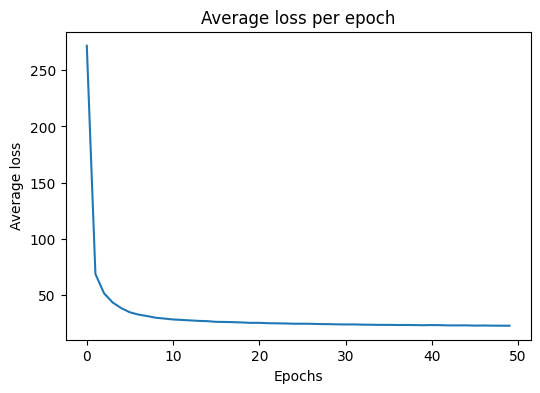

In [11]:
#@title The plot of the average losses
plt.figure(figsize=(6,4))
plt.plot(avg_losses)
plt.xlabel('Epochs')
plt.ylabel('Average loss')
plt.title('Average loss per epoch')
plt.show()

### Euler-Maruyama Numerical SDE Sampler

In [13]:
#@title Define the Euler-Maruyama sampler (double click to expand or collapse)

## The number of sampling steps.
num_steps =  2500#@param {'type':'integer'}
## Stopping time
T = 5.0 #@param {'type': 'number'}
def Euler_Maruyama_sampler(
    score_model,
    y,
    marginal_prob_std,
    batch_size=64,
    num_steps=num_steps,
    device='cuda',
    T=T,
    eps=1e-3,
    ):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps.
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.
    sigma: The standard deviation of the Gaussian blur for computing y.
  Returns:
    Samples.
  """

  # Set starting time
  t = T*torch.ones(batch_size, device=device)
  # Initialize x_T
  init_x = torch.randn(batch_size, 1, 28, 28, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(T, eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x

  with torch.no_grad():
    for time_step in tqdm(time_steps):
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      u = torch.cat((x, y), dim=1)
      mean_x = x + (1/2)*x*step_size + score_model(u, batch_time_step) * step_size
      x = mean_x + torch.sqrt(step_size) * torch.randn_like(x)
  # Do not include any noise in the last sampling step.
  return mean_x

### Load and Transform a Test Sample

Text(0.5, 1.0, 'Transformed image')

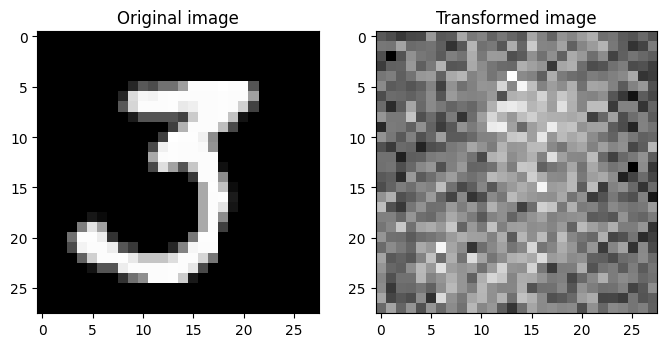

In [14]:
#@title Load and transform a test sample
seed = 1  #@param {'type':'integer'}
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Load validation samples
dataset_val = MNIST('.', train=False, transform=transforms.ToTensor(), download=True)
dataloader_val = DataLoader(dataset_val, batch_size=1, shuffle=True, num_workers=4)

# Load the random sample and compute the measurement y = A(x) + noise.
x = next(iter(dataloader_val))[0]
y = compute_y(x).to(device)

# Batch size to match x
batch_size = 64 #@param {'type':'integer'}
# Match the batch size of x.
y = y.repeat(batch_size, 1, 1, 1)

#@title Plot the orignal image and the transformed image
fig, axes = plt.subplots(1,2, figsize=(8,4))
axes[0].imshow(x[0,0,:,:].cpu(), cmap='gray')
axes[0].set_title('Original image')
axes[1].imshow(y[0,0,:,:].cpu(), cmap='gray')
axes[1].set_title('Transformed image')

### Image Reconstruction Sampling

/tmp/ipykernel_95843/2873061737.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/2500 [00:00<?, ?it/s]

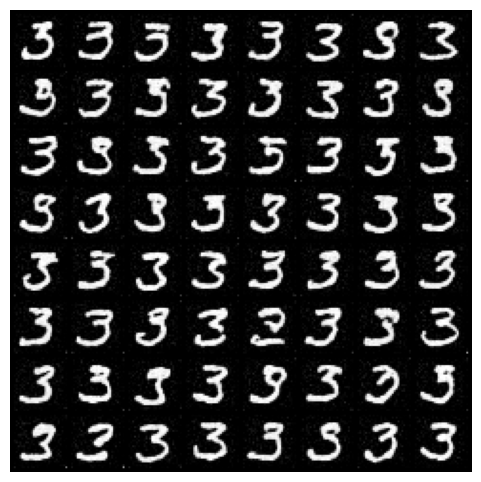

In [19]:
#@title Sampling (double click to expand or collapse)

## Load the pre-trained checkpoint from disk.
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64 #@param {'type':'integer'}
sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples = sampler(score_model,
                  y,
                  marginal_prob_std,
                  sample_batch_size,
                  device=device
                  )

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()